In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt


### 1. Loading the Dataset and Feature Set

**Objective:**  
In this step, we load the cleaned BER dataset along with the prepared feature set (`df_feature`) from the previous notebook.  
This allows us to separate **features** and **target** for subsequent modeling and feature selection.

In [2]:
# Load the cleaned BER dataset
df = pd.read_csv(r'..\dataset\BERPublicsearch_Cleaned.csv')
print("Loaded BER dataset with shape:", df.shape)

Loaded BER dataset with shape: (50000, 124)


In [3]:
# Load the prepared feature dataframe
df_feature = pd.read_csv(r'..\dataset\BER_Features_Prepared.csv')
print("Loaded feature dataframe with shape:", df_feature.shape)

Loaded feature dataframe with shape: (50000, 112)


### 2. Feature Selection Using Ensemble Model Importance

**Objective:**  
Rank features based on their contribution to predicting **BER Rating** using an ensemble of three complementary models:  
1. **Random Forest Regressor** – captures non-linear relationships and interactions.  
2. **Gradient Boosting Regressor** – emphasizes high-error predictions and sequential learning.  
3. **Lasso Regression (with CV)** – identifies sparse linear relationships and performs built-in feature selection.  

This approach allows us to leverage different modeling perspectives, mitigating bias from a single model. 


In [4]:
X = df_feature.copy()
y = df['BerRating'].copy()

In [5]:
# Identify categorical and numerical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [6]:
# Preprocessor for numeric and categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [7]:
# Dictionary to store importance DataFrames
importance_frames = {}

#### Random Forest

In [8]:
# --- Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=0)

In [9]:
# Create a pipeline for preprocessing and model training
rf_feature_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess numeric and categorical features
    ('random_forest', rf_model)      # Fit the Random Forest model
])

In [10]:
# Fit the pipeline to the full dataset
rf_feature_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition', 'MPCDERValue',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHe...
                                                   'SolarHotWaterHeating',
                                                   'ElecImmersionInSummer',
                                                   'CombiBoiler',
                                                   'KeepHotFacility',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'CylinderStat',
                                                   'CombinedCylinder',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'FirstEnergyType_Description',
                                                   'SecondEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('random_forest',
                 RandomForestRegressor(n_estimators=200, random_state=0))])

In [11]:
rf_importances = rf_feature_pipeline.named_steps['random_forest'].feature_importances_
rf_features = list(num_cols) + list(
    rf_feature_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [12]:
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'RF_Importance': rf_importances})
rf_importance_df.sort_values(by='RF_Importance', ascending=False, inplace=True)
rf_importance_df.head(10)

,Feature,RF_Importance
2,UValueWall,0.395892
15,MPCDERValue,0.287519
5,UValueWindow,0.172326
3,UValueRoof,0.040072
13,HSMainSystemEfficiency,0.014692
4,UValueFloor,0.010639
0,Year_of_Construction,0.010586
75,FirstEnerProdDelivered,0.009045
53,PrimaryEnergyMainSpace,0.005560
19,WHMainSystemEff,0.005121


#### Gradient Boosting

In [13]:
# --- Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=0)

In [14]:
# Create a pipeline for preprocessing and model training
gb_feature_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gradient_boosting', gb_model)
])

In [15]:
# Fit the pipeline to the full dataset
gb_feature_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition', 'MPCDERValue',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHe...
                                                   'ElecImmersionInSummer',
                                                   'CombiBoiler',
                                                   'KeepHotFacility',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'CylinderStat',
                                                   'CombinedCylinder',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'FirstEnergyType_Description',
                                                   'SecondEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('gradient_boosting',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,
                                           random_state=0))])

In [16]:
# Get feature importances
gb_importances = gb_feature_pipeline.named_steps['gradient_boosting'].feature_importances_
gb_features = list(num_cols) + list(
    gb_feature_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [17]:
gb_importance_df = pd.DataFrame({'Feature': gb_features, 'GB_Importance': gb_importances})
gb_importance_df.sort_values(by='GB_Importance', ascending=False, inplace=True)
gb_importance_df.head(10)

,Feature,GB_Importance
2,UValueWall,0.341342
15,MPCDERValue,0.264867
5,UValueWindow,0.130826
3,UValueRoof,0.067825
4,UValueFloor,0.056039
33,TempAdjustment,0.035256
0,Year_of_Construction,0.017969
13,HSMainSystemEfficiency,0.017848
19,WHMainSystemEff,0.014768
75,FirstEnerProdDelivered,0.009900


#### Lasso CV

In [18]:
# --- LassoCV
lasso_model = LassoCV(cv=5, random_state=0)

In [19]:
# Create a pipeline for preprocessing and model training
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', lasso_model)
])

In [20]:
lasso_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year_of_Construction',
                                                   'GroundFloorArea(sq m)',
                                                   'UValueWall', 'UValueRoof',
                                                   'UValueFloor',
                                                   'UValueWindow', 'UvalueDoor',
                                                   'WallArea', 'RoofArea',
                                                   'FloorArea', 'WindowArea',
                                                   'DoorArea', 'NoStoreys',
                                                   'HSMainSystemEfficiency',
                                                   'TGDLEdition', 'MPCDERValue',
                                                   'HSEffAdjFactor',
                                                   'HSSupplHe...
                                                   'ManuLossFactorAvail',
                                                   'SolarHotWaterHeating',
                                                   'ElecImmersionInSummer',
                                                   'CombiBoiler',
                                                   'KeepHotFacility',
                                                   'InsulationType',
                                                   'PrimaryCircuitLoss',
                                                   'CylinderStat',
                                                   'CombinedCylinder',
                                                   'ThermalMassCategory',
                                                   'PredominantRoofType',
                                                   'FirstEnergyType_Description',
                                                   'SecondEnergyType_Description',
                                                   'FirstWallType_Description'])])),
                ('lasso', LassoCV(cv=5, random_state=0))])

In [21]:
lasso_coefs = abs(lasso_pipeline.named_steps['lasso'].coef_)
lasso_features = list(num_cols) + list(
    lasso_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)

In [22]:
lasso_importance_df = pd.DataFrame({'Feature': lasso_features, 'Lasso_Importance': lasso_coefs})
lasso_importance_df.sort_values(by='Lasso_Importance', ascending=False, inplace=True)
lasso_importance_df.head(10)

,Feature,Lasso_Importance
1,GroundFloorArea(sq m),0.752635
40,DistributionLosses,0.118359
13,HSMainSystemEfficiency,0.035081
75,FirstEnerProdDelivered,0.021291
71,PrimaryEnergySupplementaryWater,0.015169
52,PrimaryEnergyMainWater,0.013613
53,PrimaryEnergyMainSpace,0.011862
70,PrimaryEnergySecondarySpace,0.011789
50,PrimaryEnergyLighting,0.010021
57,CO2MainSpace,0.009361


### Aggregated Feature Importance Across Models

In this step, we **merge the feature importances** from the three models (Random Forest, Gradient Boosting, and Lasso) into a single table.  
We then **aggregate by base feature** to account for categorical features that were one-hot encoded, producing a unified importance score per feature.  

In [23]:
importance_df = rf_importance_df.merge(gb_importance_df, on='Feature', how='outer') \
                                .merge(lasso_importance_df, on='Feature', how='outer')

In [24]:
# Define a function to extract base feature
def get_base_feature(feature_name, original_features):
    """
    - Keep original numeric/features intact.
    - For one-hot encoded categorical features (not in original_features), remove the last suffix after '_'.
    """
    if feature_name in original_features:
        return feature_name
    elif '_' in feature_name:
        return feature_name.rsplit('_', 1)[0]
    else:
        return feature_name

# List of original features (from your df_feature)
original_features = df_feature.columns.tolist()

In [25]:
importance_df['BaseFeature'] = importance_df['Feature'].apply(lambda x: get_base_feature(x, original_features))

# Aggregate importance scores by BaseFeature
agg_importance = importance_df.groupby('BaseFeature').agg({
    'RF_Importance': 'mean',
    'GB_Importance': 'mean',
    'Lasso_Importance': 'mean'
}).reset_index()

# Sort by mean importance (optional)
agg_importance['MeanImportance'] = agg_importance[['RF_Importance','GB_Importance','Lasso_Importance']].mean(axis=1)
agg_importance = agg_importance.sort_values(by='MeanImportance', ascending=False).drop(columns='MeanImportance')

In [26]:
agg_importance

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance
36,GroundFloorArea(sq m),0.001578,0.005562,0.752635
98,UValueWall,0.395892,0.341342,0.000000
52,MPCDERValue,0.287519,0.264867,0.000000
99,UValueWindow,0.172326,0.130826,0.000000
15,DistributionLosses,0.001309,0.001737,0.118359
...,...,...,...,...
9,DeclaredLossFactor,0.000010,0.000000,0.000000
81,SecondEnergyType_Description,0.000006,0.000000,0.000000
86,StructureType,0.000005,0.000000,0.000000
100,UndergroundHeating,0.000005,0.000000,0.000000


In [45]:
# Compute mean importance across models for overall ranking
agg_importance['MeanImportance'] = agg_importance[['RF_Importance', 'GB_Importance', 'Lasso_Importance']].mean(axis=1)

# Sort by mean importance descending
ranking_df = agg_importance.sort_values(by='MeanImportance', ascending=False).reset_index(drop=True)

# Add a rank column
ranking_df['Rank'] = ranking_df['MeanImportance'].rank(method='min', ascending=False).astype(int)

# Reorder columns for clarity
ranking_df = ranking_df[['Rank', 'BaseFeature', 'RF_Importance', 'GB_Importance', 'Lasso_Importance', 'MeanImportance']]


In [53]:
ranking_df.head(30)

,Rank,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,MeanImportance
0,1,GroundFloorArea(sq m),0.001578,0.005562,0.752635,0.253259
1,2,UValueWall,0.395892,0.341342,0.000000,0.245745
2,3,MPCDERValue,0.287519,0.264867,0.000000,0.184129
3,4,UValueWindow,0.172326,0.130826,0.000000,0.101051
4,5,DistributionLosses,0.001309,0.001737,0.118359,0.040468
5,6,UValueRoof,0.040072,0.067825,0.000000,0.035966
6,7,HSMainSystemEfficiency,0.014692,0.017848,0.035081,0.022540
7,8,UValueFloor,0.010639,0.056039,0.000000,0.022226
8,9,FirstEnerProdDelivered,0.009045,0.009900,0.021291,0.013412
9,10,TempAdjustment,0.000276,0.035256,0.000000,0.011844


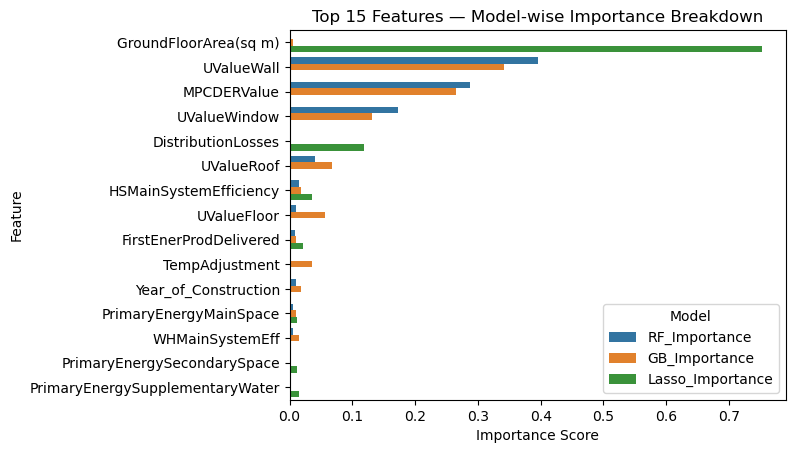

In [54]:
top_features = ranking_df.head(15)

top_features_melted = top_features.melt(
    id_vars=['BaseFeature'], 
    value_vars=['RF_Importance', 'GB_Importance', 'Lasso_Importance'], 
    var_name='Model', 
    value_name='Importance'
)

sns.barplot(
    data=top_features_melted, 
    x='Importance', 
    y='BaseFeature', 
    hue='Model', 
    orient='h'
)
plt.title('Top 15 Features — Model-wise Importance Breakdown')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='Model')


### Incorporating Feature Practicality

Next, we **merge the aggregated feature importance table with the feature lookup**.  
The lookup contains metadata about each feature, such as its **category** and **ease of acquisition** (practicality).  

In [55]:
# Load feature lookup (with categories and practicality info)
feature_lookup = pd.read_csv(r'..\dataset\BER_feature_Lookup.csv')

# Merge ranking with lookup on BaseFeature / Feature
ranking_with_lookup = ranking_df.merge(
    feature_lookup,
    left_on='BaseFeature',
    right_on='Feature',
    how='left'
)

ranking_with_lookup = ranking_with_lookup[['Rank', 'BaseFeature', 'Category', 'Availability', 
                                           'RF_Importance', 'GB_Importance', 'Lasso_Importance', 'MeanImportance']]

In [56]:
ranking_with_lookup.head()

,Rank,BaseFeature,Category,Availability,RF_Importance,GB_Importance,Lasso_Importance,MeanImportance
0,1,GroundFloorArea(sq m),Geometry,Easy,0.001578,0.005562,0.752635,0.253259
1,2,UValueWall,Envelope,Medium,0.395892,0.341342,0.000000,0.245745
2,3,MPCDERValue,Heating / Mechanical System,Moderate,0.287519,0.264867,0.000000,0.184129
3,4,UValueWindow,Envelope,Medium,0.172326,0.130826,0.000000,0.101051
4,5,DistributionLosses,Losses,Medium,0.001309,0.001737,0.118359,0.040468


In [57]:
# Compute a PracticalScore by combining MeanImportance and Availability weight
availability_weight = {'Easy': 1.0, 'Medium': 0.7, 'Hard': 0.4}
ranking_with_lookup['AvailabilityWeight'] = ranking_with_lookup['Availability'].map(availability_weight)

# Compute final practical score (MeanImportance * AvailabilityWeight)
ranking_with_lookup['PracticalScore'] = ranking_with_lookup['MeanImportance'] * ranking_with_lookup['AvailabilityWeight']

# Handle missing PracticalScore safely before ranking
ranking_with_lookup['PracticalScore'] = ranking_with_lookup['PracticalScore'].fillna(0)

# Sort and rank
ranking_with_lookup = ranking_with_lookup.sort_values(by='PracticalScore', ascending=False).reset_index(drop=True)
ranking_with_lookup['PracticalRank'] = (
    ranking_with_lookup['PracticalScore'].rank(method='min', ascending=False)
    .fillna(0)
    .astype(int)
)

# Reorder columns
ranking_with_lookup = ranking_with_lookup[['PracticalRank', 'BaseFeature', 'Category', 'Availability',
                                           'RF_Importance', 'GB_Importance', 'Lasso_Importance',
                                           'MeanImportance', 'AvailabilityWeight', 'PracticalScore']]

ranking_with_lookup.head(15)

,PracticalRank,BaseFeature,Category,Availability,RF_Importance,GB_Importance,Lasso_Importance,MeanImportance,AvailabilityWeight,PracticalScore
0,1,GroundFloorArea(sq m),Geometry,Easy,0.001578,0.005562,0.752635,0.253259,1.0,0.253259
1,2,UValueWall,Envelope,Medium,0.395892,0.341342,0.000000,0.245745,0.7,0.172021
2,3,UValueWindow,Envelope,Medium,0.172326,0.130826,0.000000,0.101051,0.7,0.070735
3,4,DistributionLosses,Losses,Medium,0.001309,0.001737,0.118359,0.040468,0.7,0.028328
4,5,UValueRoof,Envelope,Medium,0.040072,0.067825,0.000000,0.035966,0.7,0.025176
5,6,HSMainSystemEfficiency,Heating Efficiency,Medium,0.014692,0.017848,0.035081,0.022540,0.7,0.015778
6,7,UValueFloor,Envelope,Medium,0.010639,0.056039,0.000000,0.022226,0.7,0.015558
7,8,Year_of_Construction,Geometry,Easy,0.010586,0.017969,0.000000,0.009519,1.0,0.009519
8,9,TempAdjustment,Ventilation,Medium,0.000276,0.035256,0.000000,0.011844,0.7,0.008291
9,10,WHMainSystemEff,Hot Water,Medium,0.005121,0.014768,0.000000,0.006629,0.7,0.004641


In [59]:
ranking_with_lookup.to_csv('../dataset/final_feature_ranking.csv', index=False)